In [1]:
import pandas as pd
import numpy as np
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder

import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import BatchNormalization, Dropout, Input, Embedding, Flatten, Concatenate, Dense
from tensorflow.keras.metrics import MeanAbsoluteError, RootMeanSquaredError, R2Score
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Nadam

from Funcoes_Comuns import avaliar_modelo, registrar_modelo

In [2]:
# Definir a semente para reprodutibilidade
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

Recuperar base já pré-processada

In [3]:
# Obter dados
df_enem = pd.read_pickle('Bases\MICRODADOS_ENEM_2023_tratados.pkl')

In [4]:
df_enem.head()

,BIN_Q001_DUMMY_H,BIN_Q002_DUMMY_H,BIN_Q018,BIN_Q020,BIN_Q021,BIN_Q023,BIN_Q025,CAT_COR_RACA,CAT_CO_MUNICIPIO_ESC,CAT_CO_UF_ESC,...,NUM_Q011,NUM_Q012,NUM_Q013,NUM_Q014,NUM_Q015,NUM_Q016,NUM_Q017,NUM_Q019,NUM_Q022,NUM_Q024
0,False,False,False,False,False,False,True,3,2304400,23,...,0,1,0,0,0,0,0,1,3,0
1,False,False,False,False,False,False,False,3,2311306,23,...,0,1,0,0,0,0,0,1,1,0
2,False,False,False,False,False,False,True,3,4128005,41,...,0,1,0,1,0,0,0,1,1,1
3,False,False,False,False,False,True,True,1,1501402,15,...,0,1,0,0,0,0,0,1,3,0
4,False,False,False,False,False,False,True,1,3550308,35,...,0,1,0,1,0,0,0,1,1,0


Parâmetros

In [5]:
variaveis_alvo = ['NUM_NOTA_MT', 'NUM_NOTA_LC', 'NUM_NOTA_CN', 'NUM_NOTA_CH', 'NUM_NOTA_REDACAO']
grupo_previsao = ['NUM_NOTA_CH']

One-hot Encoding

In [6]:
# Remover CAT_CO_MUNICIPIO_ESC devido alta cardinalidade
df_enem = df_enem.drop(columns=['CAT_CO_MUNICIPIO_ESC'])

In [7]:
# Aplicar o OneHotEncoder para converter as colunas categóricas em variáveis dummy
categorical_columns = df_enem.select_dtypes(include=['category']).columns
df_enem = pd.get_dummies(df_enem, columns=categorical_columns, drop_first=True)

In [8]:
df_enem.head()

,BIN_Q001_DUMMY_H,BIN_Q002_DUMMY_H,BIN_Q018,BIN_Q020,BIN_Q021,BIN_Q023,BIN_Q025,NUM_NOTA_CH,NUM_NOTA_CN,NUM_NOTA_LC,...,CAT_Q003_F,CAT_Q004_B,CAT_Q004_C,CAT_Q004_D,CAT_Q004_E,CAT_Q004_F,CAT_SEXO_M,CAT_SIT_FUNC_ESC_2,CAT_SIT_FUNC_ESC_3,CAT_SIT_FUNC_ESC_4
0,False,False,False,False,False,False,True,508.5,459.0,507.2,...,False,True,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,379.2,402.5,446.9,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,True,667.6,608.2,607.9,...,False,True,False,False,False,False,True,False,False,False
3,False,False,False,False,False,True,True,553.1,515.7,544.4,...,False,True,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,True,576.3,523.8,596.5,...,False,True,False,False,False,False,True,False,False,False


In [9]:
# separar em treino e teste
X = df_enem.drop(columns=variaveis_alvo)
y = df_enem[grupo_previsao]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [10]:
# Criar grupo de validação (15% do conjunto de treino)
X_train, X_eval, y_train, y_eval = train_test_split(
    X_train,
    y_train,
    test_size=0.15,
    random_state=42
)

Normalização -> Testar StandardScaler (melhor) e MinMaxScaler

In [11]:
# Identificar colunas booleanas e outras
bool_cols_X = X_train.select_dtypes(include=['bool']).columns
num_cols_X = X_train.select_dtypes(include=[np.number]).columns.difference(bool_cols_X)

In [12]:
X_train

,BIN_Q001_DUMMY_H,BIN_Q002_DUMMY_H,BIN_Q018,BIN_Q020,BIN_Q021,BIN_Q023,BIN_Q025,NUM_Q001,NUM_Q002,NUM_Q005,...,CAT_Q003_F,CAT_Q004_B,CAT_Q004_C,CAT_Q004_D,CAT_Q004_E,CAT_Q004_F,CAT_SEXO_M,CAT_SIT_FUNC_ESC_2,CAT_SIT_FUNC_ESC_3,CAT_SIT_FUNC_ESC_4
713684,True,True,False,False,False,False,True,4,4,5,...,True,False,False,False,False,True,True,False,False,False
518205,False,False,False,False,True,False,True,3,3,4,...,False,True,False,False,False,False,True,False,False,False
207306,False,False,False,False,False,False,True,3,4,4,...,True,False,False,False,False,True,True,False,False,False
469659,False,False,True,True,True,False,True,4,4,4,...,False,True,False,False,False,False,True,False,False,False
140617,False,False,False,False,False,False,True,2,2,6,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329019,False,False,False,True,True,False,True,2,4,3,...,False,True,False,False,False,False,True,False,False,False
251563,False,False,False,True,True,False,True,6,5,4,...,False,False,False,True,False,False,False,False,False,False
359279,False,False,True,False,True,True,True,6,5,2,...,False,False,False,False,True,False,False,False,False,False
570727,False,False,True,True,True,True,True,5,5,4,...,False,False,False,True,False,False,False,False,False,False


In [13]:
# Normalizar X - Referencia apenas cunjunto de treino
X_scaler = StandardScaler()
X_train[num_cols_X] = X_scaler.fit_transform(X_train[num_cols_X])
X_eval[num_cols_X] = X_scaler.transform(X_eval[num_cols_X])
X_test[num_cols_X] = X_scaler.transform(X_test[num_cols_X])

# Normalizar y - Referencia apenas cunjunto de treino (não há colunas booleanas)
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train)
y_eval = y_scaler.transform(y_eval)
y_test = y_scaler.transform(y_test)

In [14]:
# Converter dados para modelo - redes neurais esperam dados em numpy arrays
X_train = X_train.astype(np.float32)
X_eval = X_eval.astype(np.float32)
X_test = X_test.astype(np.float32)

y_train = y_train.astype(np.float32)
y_eval = y_eval.astype(np.float32)
y_test = y_test.astype(np.float32)

Modelo base (sem variável CAT_CO_MUNICIPIO_ESC devido alta dimensionalidade do One-Hot)

In [15]:
# Construir a rede neural com 5 camadas
model = Sequential([
    Input(shape=(X_train.shape[1],)),                      # Camada de entrada
    Dense(64, activation='relu'),                          # Camada oculta 1
    Dense(32, activation='relu'),                          # Camada oculta 2
    Dense(16, activation='relu'),                          # Camada oculta 3
    Dense(8, activation='relu'),                           # Camada oculta 4
    Dense(units=len(grupo_previsao), activation='linear')  # Camada de saída para regressão: 1 variável, ativação linear
])

In [16]:
# Parametros de parada
early_stopping = EarlyStopping(
    monitor='val_loss',           # Monitorar a perda no conjunto de validação
    patience=5,                   # Parar após n épocas sem melhoria
    mode='min',                   # Minimizar a perda
    restore_best_weights=True     # Restaurar os melhores pesos encontrados
)

# Compilar o modelo
model.compile(
    optimizer='adam',
    loss='mse',        # Função de perda
    metrics=[MeanAbsoluteError(), RootMeanSquaredError(), R2Score()]
)

In [17]:
# Treinar o modelo

start_time = time.time()

history = model.fit(
    X_train, 
    y_train,
    validation_data=(X_eval, y_eval),    # Usar o conjunto validação
    epochs=50,                           # Número máximo de épocas
    batch_size=256,                      # Tamanho do batch
    callbacks=[early_stopping],          # Usar early stopping
    verbose=1
)

tempo_treino = time.time() - start_time

Epoch 1/50
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.7382 - mean_absolute_error: 0.6805 - r2_score: 0.2610 - root_mean_squared_error: 0.8587 - val_loss: 0.6995 - val_mean_absolute_error: 0.6576 - val_r2_score: 0.3001 - val_root_mean_squared_error: 0.8364
Epoch 2/50
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.6938 - mean_absolute_error: 0.6569 - r2_score: 0.3053 - root_mean_squared_error: 0.8330 - val_loss: 0.6961 - val_mean_absolute_error: 0.6557 - val_r2_score: 0.3035 - val_root_mean_squared_error: 0.8344
Epoch 3/50
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.6901 - mean_absolute_error: 0.6548 - r2_score: 0.3091 - root_mean_squared_error: 0.8307 - val_loss: 0.6947 - val_mean_absolute_error: 0.6548 - val_r2_score: 0.3050 - val_root_mean_squared_error: 0.8335
Epoch 4/50
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.6877 - mean_absolute_error: 0.6537 - r2_score: 0.3115 - root_mean_squared_error: 0.8293 - val_loss: 0.6944 - val_mean_absolute_error: 0.65

In [18]:
# Avaliar o modelo no conjunto de teste
model.evaluate(X_test, y_test, verbose=1)

4479/4479 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.6916 - mean_absolute_error: 0.6519 - r2_score: 0.3079 - root_mean_squared_error: 0.8316


[0.6929412484169006, 0.6533617973327637, 0.832430899143219, 0.305519163608551]

    Com uso de one-hot
    Impossível com o hardware atual

    Com uso de one-hot encoder sem Código do Municipio (Possui mais de 5000 categorias)
    [50.6934848427772522, 0.6552520394325256, 0.8327573537826538, 0.304974317550659]

In [19]:
# Previsões
y_pred = model.predict(X_test)

4479/4479 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


In [20]:
# Desnormalizar
y_test_desnorm = y_scaler.inverse_transform(y_test)
y_pred_desnorm = y_scaler.inverse_transform(y_pred)
y_train_desnorm = y_scaler.inverse_transform(y_train)

In [21]:
nome_experimento = 'Notas CH ENEM 2023'

# Registrar modelo no MLflow
registrar_modelo(experimento=nome_experimento,
                 parametros={
                        'batch_size': 256,
                        'epochs': len(history.history['loss']),
                        'loss': history.history['loss'][-1],
                        'val_loss': history.history['val_loss'][-1],
                        'mae': history.history['mean_absolute_error'][-1],
                        'rmse': history.history['root_mean_squared_error'][-1],
                        'r2_score': history.history['r2_score'][-1],
                        'tempo': tempo_treino,
                        'amostra': len(X_train),
                        'embedding_dim': 0,  # Não foi utilizado embedding
                        'patience': early_stopping.patience,
                        'optimizer': 'adam',
                        'learning_rate': model.optimizer.learning_rate.numpy(),
                        'dropout_rate': 0.0,  # Não foi utilizado dropout
                        'batch_normalization': False,
                    },
                 X_train=X_train,
                 y_train=pd.DataFrame(y_train_desnorm, columns=grupo_previsao),
                 y_test=pd.DataFrame(y_test_desnorm, columns=grupo_previsao),
                 y_pred=pd.DataFrame(y_pred_desnorm, columns=grupo_previsao),
                 variavel_alvo= grupo_previsao[0],
                 modelo=model,
                 nome_modelo='modelo_RNA_base_sem_municipio',
                 descricao_modelo='Modelo de RNA base sem utilização do código do município'
                )

Registered model 'modelo_RNA_base_sem_municipio' already exists. Creating a new version of this model...
2025/06/02 14:53:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: modelo_RNA_base_sem_municipio, version 4


🏃 View run amazing-lynx-829 at: http://127.0.0.1:9080/#/experiments/957135083854196683/runs/24f0e46f9b04498a8a5cacb5e70bace5
🧪 View experiment at: http://127.0.0.1:9080/#/experiments/957135083854196683
Modelo registrado com sucesso no MLflow: modelo_RNA_base_sem_municipio
Rastreamento do MLflow finalizado.


Created version '4' of model 'modelo_RNA_base_sem_municipio'.


In [22]:
# Avaliação grupo treino
avaliar_modelo(y_train_desnorm,
               y_scaler.inverse_transform(model.predict(X_train)), 
               "treino")

# Avaliação grupo teste
avaliar_modelo(y_test_desnorm,
               y_pred_desnorm,
               "teste")

15228/15228 ━━━━━━━━━━━━━━━━━━━━ 22s 1ms/step
MAE (treino): 55.0011
RMSE (treino): 70.0707
R2 (treino): 0.3145
MAE (teste): 55.2965
RMSE (teste): 70.4517
R2 (teste): 0.3055


In [23]:
# Salvar o modelo otimizado como um arquivo
model.save('Modelos\modelo_RNA_base.h5')

Testar Embedding para coluna CO_MUNICIPIO_ESC

In [24]:
# Obter dados
df_enem = pd.read_pickle('Bases\MICRODADOS_ENEM_2023_tratados.pkl')

In [25]:
# 1. Separar a coluna de alta cardinalidade
municipio_col = 'CAT_CO_MUNICIPIO_ESC'
municipios = df_enem[municipio_col].astype(str)  # garantir string para LabelEncoder
X_features = df_enem.drop(columns=[municipio_col] + variaveis_alvo)

In [26]:
# 2. Codificar a coluna como inteiros
le_municipio = LabelEncoder()
municipios_encoded = le_municipio.fit_transform(municipios)

In [27]:
# 3. One-hot para as demais features
categorical_columns = X_features.select_dtypes(include=['category']).columns
X_features = pd.get_dummies(X_features, columns=categorical_columns, drop_first=True)

    f: features
    m: municipios

In [28]:
# 4. Separar treino/teste/validação para ambos
X_train_f, X_test_f, X_train_m, X_test_m, y_train, y_test = train_test_split(
    X_features, municipios_encoded, df_enem[grupo_previsao], test_size=0.2, random_state=seed
)
X_train_f, X_eval_f, X_train_m, X_eval_m, y_train, y_eval = train_test_split(
    X_train_f, X_train_m, y_train, test_size=0.15, random_state=seed
)

In [29]:
# 5. Normalizar demais features e y
# Normalizar X - Referencia apenas cunjunto de treino
X_scaler = StandardScaler()
X_train_f = X_scaler.fit_transform(X_train_f)
X_eval_f = X_scaler.transform(X_eval_f)
X_test_f = X_scaler.transform(X_test_f)

# Normalizar y - Referencia apenas cunjunto de treino (não há colunas booleanas)
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train)
y_eval = y_scaler.transform(y_eval)
y_test = y_scaler.transform(y_test)

In [30]:
# 6. Converter dados para modelo - redes neurais esperam dados em numpy arrays
X_train_f = X_train_f.astype(np.float32)
X_eval_f = X_eval_f.astype(np.float32)
X_test_f = X_test_f.astype(np.float32)

y_train = y_train.astype(np.float32)
y_eval = y_eval.astype(np.float32)
y_test = y_test.astype(np.float32)

In [31]:
# 7. Modelo funcional com embedding

# Inputs
input_features = Input(shape=(X_train_f.shape[1],), name='features')
input_municipio = Input(shape=(1,), name='municipio')

In [32]:
# Embedding
n_municipios = len(le_municipio.classes_)
embedding_dim = 16  # escolha um valor pequeno, ex: 8~32
x_municipio = Embedding(input_dim=n_municipios, output_dim=embedding_dim)(input_municipio)
x_municipio = Flatten()(x_municipio)

In [33]:
# Concatenar
x = Concatenate()([input_features, x_municipio])

In [34]:
# Camadas densas
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
x = Dense(8, activation='relu')(x)
output = Dense(len(grupo_previsao), activation='linear')(x)

model_embedding = Model(inputs=[input_features, input_municipio], outputs=output)

In [35]:
# Parametros de parada
early_stopping = EarlyStopping(
    monitor='val_loss',           # Monitorar a perda no conjunto de validação
    patience=5,                   # Parar após n épocas sem melhoria
    mode='min',                   # Minimizar a perda
    restore_best_weights=True     # Restaurar os melhores pesos encontrados
)

# Compilar
model_embedding.compile(
    optimizer='adam',
    loss='mse',
    metrics=[MeanAbsoluteError(), RootMeanSquaredError(), R2Score()]
)

In [36]:
start_time = time.time()

# Treinar o modelo com embedding
history = model_embedding.fit(
    [X_train_f, X_train_m], y_train,
    validation_data=([X_eval_f, X_eval_m], y_eval),
    epochs=50,
    batch_size=256,
    callbacks=[early_stopping],
    verbose=1
)

tempo_treino = time.time() - start_time

Epoch 1/50
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.7370 - mean_absolute_error: 0.6784 - r2_score: 0.2621 - root_mean_squared_error: 0.8580 - val_loss: 0.6930 - val_mean_absolute_error: 0.6548 - val_r2_score: 0.3067 - val_root_mean_squared_error: 0.8324
Epoch 2/50
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.6830 - mean_absolute_error: 0.6509 - r2_score: 0.3162 - root_mean_squared_error: 0.8265 - val_loss: 0.6901 - val_mean_absolute_error: 0.6539 - val_r2_score: 0.3095 - val_root_mean_squared_error: 0.8307
Epoch 3/50
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.6762 - mean_absolute_error: 0.6473 - r2_score: 0.3230 - root_mean_squared_error: 0.8223 - val_loss: 0.6902 - val_mean_absolute_error: 0.6536 - val_r2_score: 0.3095 - val_root_mean_squared_error: 0.8308
Epoch 4/50
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.6719 - mean_absolute_error: 0.6450 - r2_score: 0.3273 - root_mean_squared_error: 0.8197 - val_loss: 0.6906 - val_mean_absolute_error: 0.6

In [37]:
# Avaliar o modelo no conjunto de teste
model_embedding.evaluate([X_test_f, X_test_m], y_test, verbose=1)

4479/4479 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.6866 - mean_absolute_error: 0.6512 - r2_score: 0.3128 - root_mean_squared_error: 0.8286


[0.6888033747673035,
 0.6528632044792175,
 0.8299418091773987,
 0.3096662163734436]

In [38]:
# Previsões
y_pred = model_embedding.predict([X_test_f, X_test_m])

4479/4479 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step


In [39]:
# Desnormalizar
y_test_desnorm = y_scaler.inverse_transform(y_test)
y_pred_desnorm = y_scaler.inverse_transform(y_pred)
y_train_desnorm = y_scaler.inverse_transform(y_train)

In [40]:
nome_experimento = 'Notas CH ENEM 2023'

# Registrar modelo no MLflow
registrar_modelo(experimento=nome_experimento,
                 parametros={
                        'batch_size': 256,
                        'epochs': len(history.history['loss']),
                        'loss': history.history['loss'][-1],
                        'val_loss': history.history['val_loss'][-1],
                        'mae': history.history['mean_absolute_error'][-1],
                        'rmse': history.history['root_mean_squared_error'][-1],
                        'r2_score': history.history['r2_score'][-1],
                        'tempo': tempo_treino,
                        'amostra': len(X_train_f),
                        'embedding_dim': embedding_dim,
                        'patience': early_stopping.patience,
                        'optimizer': 'adam',
                        'learning_rate': model_embedding.optimizer.learning_rate.numpy(),
                        'dropout_rate': 0.0,  # Não foi utilizado dropout
                        'batch_normalization': False,
                    },
                 X_train=X_train_f,
                 y_train=pd.DataFrame(y_train_desnorm, columns=grupo_previsao),
                 y_test=pd.DataFrame(y_test_desnorm, columns=grupo_previsao),
                 y_pred=pd.DataFrame(y_pred_desnorm, columns=grupo_previsao),
                 variavel_alvo= grupo_previsao[0],
                 modelo=model_embedding,
                 nome_modelo='modelo_RNA_embedding_municipio',
                 descricao_modelo='Modelo de RNA com embedding para o código do município'
                )

Registered model 'modelo_RNA_embedding_municipio' already exists. Creating a new version of this model...
2025/06/02 14:55:14 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: modelo_RNA_embedding_municipio, version 3


🏃 View run clumsy-swan-934 at: http://127.0.0.1:9080/#/experiments/957135083854196683/runs/70201218c0c34b54b3f3bc613791d791
🧪 View experiment at: http://127.0.0.1:9080/#/experiments/957135083854196683
Modelo registrado com sucesso no MLflow: modelo_RNA_embedding_municipio
Rastreamento do MLflow finalizado.


Created version '3' of model 'modelo_RNA_embedding_municipio'.


In [42]:
# Avaliação grupo treino
avaliar_modelo(y_train_desnorm,
               y_scaler.inverse_transform(model_embedding.predict([X_train_f, X_train_m])), 
               "treino")

# Avaliação grupo teste
avaliar_modelo(y_test_desnorm,
               y_pred_desnorm,
               "teste")

15228/15228 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step
MAE (treino): 54.5869
RMSE (treino): 69.4666
R2 (treino): 0.3263
MAE (teste): 55.2542
RMSE (teste): 70.2411
R2 (teste): 0.3097


In [43]:
# Salvar o modelo otimizado como um arquivo
model_embedding.save('Modelos\modelo_RNA_base_embedding.h5')

    Modelo com Embedding se saiu melhor

    Indica que o município da escola importa
    
    Bom sinal para inclusão dos dados do censo que detalham mais as características da escola de cada município

Deixar modelo mais elaborado: parametros melhores, camadas

    Utilizar otimizador Nadam
    Mudar learning rate
    Aumementar camadas
    Reduzir Batch size
    Aumentar patience (early stopping)

In [44]:
# Inputs
input_features = Input(shape=(X_train_f.shape[1],), name='features')
input_municipio = Input(shape=(1,), name='municipio')

# Embedding
n_municipios = len(le_municipio.classes_)
embedding_dim = 16  # escolha um valor pequeno, ex: 8~32
x_municipio = Embedding(input_dim=n_municipios, output_dim=embedding_dim)(input_municipio)
x_municipio = Flatten()(x_municipio)

# Concatenar
x = Concatenate()([input_features, x_municipio])

In [45]:
# Camadas densas
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
x = Dense(8, activation='relu')(x)
output = Dense(len(grupo_previsao), activation='linear')(x)

model_emb_param = Model(inputs=[input_features, input_municipio], outputs=output)

In [46]:
# Parametros de parada
early_stopping = EarlyStopping(
    monitor='val_loss',           # Monitorar a perda no conjunto de validação
    patience=10,                  # Parar após n épocas sem melhoria
    mode='min',                   # Minimizar a perda
    restore_best_weights=True     # Restaurar os melhores pesos encontrados
)

# Compilar e treinar
model_emb_param.compile(
    optimizer=Nadam(learning_rate=0.001),
    loss='mse',
    metrics=[MeanAbsoluteError(), RootMeanSquaredError(), R2Score()]
)

In [47]:
start_time = time.time()

# Treinar o modelo com embedding e parâmetros ajustados
history = model_emb_param.fit(
    [X_train_f, X_train_m], y_train,
    validation_data=([X_eval_f, X_eval_m], y_eval),
    epochs=50,
    batch_size=128,
    callbacks=[early_stopping],
    verbose=1
)

tempo_treino = time.time() - start_time

Epoch 1/50
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - loss: 0.7439 - mean_absolute_error: 0.6854 - r2_score: 0.2552 - root_mean_squared_error: 0.8621 - val_loss: 0.6902 - val_mean_absolute_error: 0.6542 - val_r2_score: 0.3095 - val_root_mean_squared_error: 0.8308
Epoch 2/50
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step - loss: 0.6814 - mean_absolute_error: 0.6499 - r2_score: 0.3178 - root_mean_squared_error: 0.8254 - val_loss: 0.6880 - val_mean_absolute_error: 0.6531 - val_r2_score: 0.3116 - val_root_mean_squared_error: 0.8295
Epoch 3/50
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - loss: 0.6741 - mean_absolute_error: 0.6461 - r2_score: 0.3251 - root_mean_squared_error: 0.8210 - val_loss: 0.6883 - val_mean_absolute_error: 0.6533 - val_r2_score: 0.3114 - val_root_mean_squared_error: 0.8296
Epoch 4/50
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - loss: 0.6689 - mean_absolute_error: 0.6433 - r2_score: 0.3303 - root_mean_squared_error: 0.8179 - val_loss: 0.6889 - val_mean_absolute_error: 

In [48]:
# Avaliar o modelo no conjunto de teste
model_emb_param.evaluate([X_test_f, X_test_m], y_test, verbose=1)

4479/4479 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.6854 - mean_absolute_error: 0.6506 - r2_score: 0.3141 - root_mean_squared_error: 0.8279


[0.687438428401947, 0.6521879434585571, 0.829119086265564, 0.3110342025756836]

In [49]:
# Previsões
y_pred = model_emb_param.predict([X_test_f, X_test_m])

# Desnormalizar
y_test_desnorm = y_scaler.inverse_transform(y_test)
y_pred_desnorm = y_scaler.inverse_transform(y_pred)
y_train_desnorm = y_scaler.inverse_transform(y_train)

4479/4479 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


In [50]:
nome_experimento = 'Notas CH ENEM 2023'

# Registrar modelo no MLflow
registrar_modelo(experimento=nome_experimento,
                 parametros={
                        'batch_size': 128,
                        'epochs': len(history.history['loss']),
                        'loss': history.history['loss'][-1],
                        'val_loss': history.history['val_loss'][-1],
                        'mae': history.history['mean_absolute_error'][-1],
                        'rmse': history.history['root_mean_squared_error'][-1],
                        'r2_score': history.history['r2_score'][-1],
                        'tempo': tempo_treino,
                        'amostra': len(X_train_f),
                        'embedding_dim': embedding_dim,
                        'patience': early_stopping.patience,
                        'optimizer': 'Nadam',
                        'learning_rate':model_emb_param.optimizer.learning_rate.numpy(),
                        'dropout_rate': 0.0,  # Não foi utilizado dropout
                        'batch_normalization': False,
                    },
                 X_train=X_train_f,
                 y_train=pd.DataFrame(y_train_desnorm, columns=grupo_previsao),
                 y_test=pd.DataFrame(y_test_desnorm, columns=grupo_previsao),
                 y_pred=pd.DataFrame(y_pred_desnorm, columns=grupo_previsao),
                 variavel_alvo= grupo_previsao[0],
                 modelo=model_emb_param,
                 nome_modelo='modelo_RNA_embedding_municipio_melhores_parametros',
                 descricao_modelo='Modelo de RNA com embedding para o código do município com melhores parâmetros de treinamento'
                )

Registered model 'modelo_RNA_embedding_municipio_melhores_parametros' already exists. Creating a new version of this model...
2025/06/02 15:00:36 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: modelo_RNA_embedding_municipio_melhores_parametros, version 2


🏃 View run vaunted-rook-794 at: http://127.0.0.1:9080/#/experiments/957135083854196683/runs/634d3bf967e440e296ab97b5bd37d695
🧪 View experiment at: http://127.0.0.1:9080/#/experiments/957135083854196683
Modelo registrado com sucesso no MLflow: modelo_RNA_embedding_municipio_melhores_parametros
Rastreamento do MLflow finalizado.


Created version '2' of model 'modelo_RNA_embedding_municipio_melhores_parametros'.


In [51]:
# Avaliação grupo treino
avaliar_modelo(y_train_desnorm,
               y_scaler.inverse_transform(model_emb_param.predict([X_train_f, X_train_m])), 
               "treino")

# Avaliação grupo teste
avaliar_modelo(y_test_desnorm,
               y_pred_desnorm,
               "teste")

15228/15228 ━━━━━━━━━━━━━━━━━━━━ 22s 1ms/step
MAE (treino): 54.4925
RMSE (treino): 69.3313
R2 (treino): 0.3289
MAE (teste): 55.1971
RMSE (teste): 70.1715
R2 (teste): 0.3110


Aplicar Dropout e BatchNormalization no modelo base

In [52]:
# Modelo com Embedding, Dropout e BatchNormalization

# Inputs
input_features = Input(shape=(X_train_f.shape[1],), name='features')
input_municipio = Input(shape=(1,), name='municipio')

# Embedding
n_municipios = len(le_municipio.classes_)
embedding_dim = 16  # escolha um valor pequeno, ex: 8~32
x_municipio = Embedding(input_dim=n_municipios, output_dim=embedding_dim)(input_municipio)
x_municipio = Flatten()(x_municipio)

# Concatenar
x = Concatenate()([input_features, x_municipio])

In [53]:
# Camadas densas
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
x = Dense(8, activation='relu')(x)
output = Dense(len(grupo_previsao), activation='linear')(x)

model_emb_drop_bat = Model(inputs=[input_features, input_municipio], outputs=output)

In [54]:
# Parametros de parada
early_stopping = EarlyStopping(
    monitor='val_loss',           # Monitorar a perda no conjunto de validação
    patience=10,                  # Parar após n épocas sem melhoria
    mode='min',                   # Minimizar a perda
    restore_best_weights=True     # Restaurar os melhores pesos encontrados
)

# Compilar e treinar
model_emb_drop_bat.compile(
    optimizer=Nadam(learning_rate=0.0005),
    loss='mse',
    metrics=[MeanAbsoluteError(), RootMeanSquaredError(), R2Score()]
)

In [55]:
start_time = time.time()

# Treinar modelo com embedding, dropout e batch normalization
history = model_emb_drop_bat.fit(
    [X_train_f, X_train_m], y_train,
    validation_data=([X_eval_f, X_eval_m], y_eval),
    epochs=50,
    batch_size=512,
    callbacks=[early_stopping],
    verbose=1
)

tempo_treino = time.time() - start_time

Epoch 1/50
952/952 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.8370 - mean_absolute_error: 0.7249 - r2_score: 0.1619 - root_mean_squared_error: 0.9138 - val_loss: 0.7066 - val_mean_absolute_error: 0.6643 - val_r2_score: 0.2930 - val_root_mean_squared_error: 0.8406
Epoch 2/50
952/952 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.7125 - mean_absolute_error: 0.6667 - r2_score: 0.2866 - root_mean_squared_error: 0.8441 - val_loss: 0.6945 - val_mean_absolute_error: 0.6578 - val_r2_score: 0.3052 - val_root_mean_squared_error: 0.8334
Epoch 3/50
952/952 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.6975 - mean_absolute_error: 0.6589 - r2_score: 0.3016 - root_mean_squared_error: 0.8352 - val_loss: 0.6916 - val_mean_absolute_error: 0.6562 - val_r2_score: 0.3081 - val_root_mean_squared_error: 0.8316
Epoch 4/50
952/952 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.6897 - mean_absolute_error: 0.6550 - r2_score: 0.3094 - root_mean_squared_error: 0.8305 - val_loss: 0.6903 - val_mean_absolute_error: 0.6554 - va

In [56]:
# Avaliar o modelo no conjunto de teste
model_emb_drop_bat.evaluate([X_test_f, X_test_m], y_test, verbose=1)

4479/4479 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.6851 - mean_absolute_error: 0.6527 - r2_score: 0.3144 - root_mean_squared_error: 0.8277


[0.6868043541908264,
 0.6540043950080872,
 0.8287366032600403,
 0.31166964769363403]

In [57]:
# Previsões
y_pred = model_emb_drop_bat.predict([X_test_f, X_test_m])

# Desnormalizar
y_test_desnorm = y_scaler.inverse_transform(y_test)
y_pred_desnorm = y_scaler.inverse_transform(y_pred)
y_train_desnorm = y_scaler.inverse_transform(y_train)

4479/4479 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step


In [58]:
nome_experimento = 'Notas CH ENEM 2023'

# Registrar modelo no MLflow
registrar_modelo(experimento=nome_experimento,
                 parametros={
                        'batch_size': 512,
                        'epochs': len(history.history['loss']),
                        'loss': history.history['loss'][-1],
                        'val_loss': history.history['val_loss'][-1],
                        'mae': history.history['mean_absolute_error'][-1],
                        'rmse': history.history['root_mean_squared_error'][-1],
                        'r2_score': history.history['r2_score'][-1],
                        'tempo': tempo_treino,
                        'amostra': len(X_train_f),
                        'embedding_dim': embedding_dim,
                        'patience': early_stopping.patience,
                        'optimizer': 'Nadam',
                        'learning_rate': model_emb_drop_bat.optimizer.learning_rate.numpy(),
                        'dropout_rate': 0.3,
                        'batch_normalization': True
                    },
                 X_train=X_train_f,
                 y_train=pd.DataFrame(y_train_desnorm, columns=grupo_previsao),
                 y_test=pd.DataFrame(y_test_desnorm, columns=grupo_previsao),
                 y_pred=pd.DataFrame(y_pred_desnorm, columns=grupo_previsao),
                 variavel_alvo= grupo_previsao[0],
                 modelo=model_emb_drop_bat,
                 nome_modelo='modelo_RNA_embedding_municipio_drop_bat',
                 descricao_modelo='Modelo de RNA com embedding, dropout e batch normalization para o código do município'
                )

Successfully registered model 'modelo_RNA_embedding_municipio_drop_bat'.
2025/06/02 15:04:49 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: modelo_RNA_embedding_municipio_drop_bat, version 1


🏃 View run chill-colt-634 at: http://127.0.0.1:9080/#/experiments/957135083854196683/runs/f8ee1b5463eb4f9b92780aed651e4c07
🧪 View experiment at: http://127.0.0.1:9080/#/experiments/957135083854196683
Modelo registrado com sucesso no MLflow: modelo_RNA_embedding_municipio_drop_bat
Rastreamento do MLflow finalizado.


Created version '1' of model 'modelo_RNA_embedding_municipio_drop_bat'.


In [59]:
# Avaliação grupo treino
avaliar_modelo(y_train_desnorm,
               y_scaler.inverse_transform(model_emb_drop_bat.predict([X_train_f, X_train_m])), 
               "treino")

# Avaliação grupo teste
avaliar_modelo(y_test_desnorm,
               y_pred_desnorm,
               "teste")

15228/15228 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step
MAE (treino): 54.2692
RMSE (treino): 68.8422
R2 (treino): 0.3384
MAE (teste): 55.3507
RMSE (teste): 70.1391
R2 (teste): 0.3117


In [60]:
# Salvar o modelo otimizado como um arquivo
model_emb_drop_bat.save('Modelos\modelo_RNA_base_embedding_dropout_batchnorm.h5')

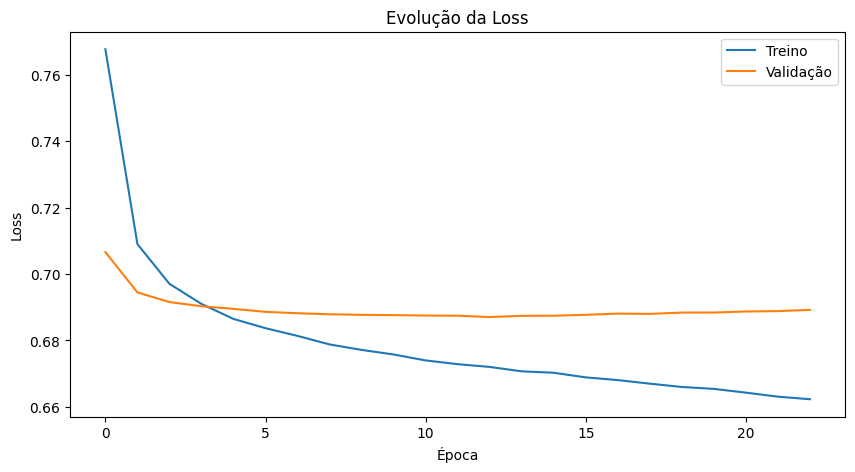

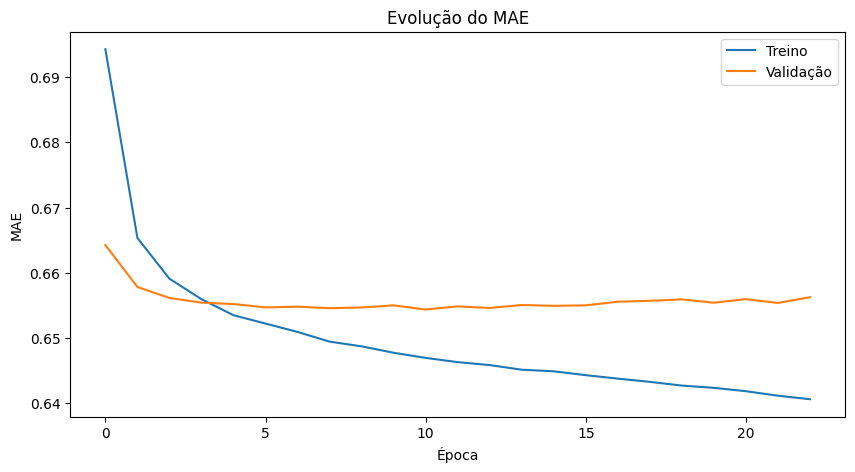

In [ ]:
import matplotlib.pyplot as plt

# Exemplo para a métrica de perda (loss)
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Perda no Conjunto de Treinamento')
plt.plot(history.history['val_loss'], label='Perda no Conjunto de Validação')
plt.title('Evolução da Perda (Loss) do Modelo durante o Treinamento - Notas de Ciências Humanas')
plt.xlabel('Número de Épocas')
plt.ylabel('Erro do Modelo (Loss)')
plt.legend()
plt.show()

# Para outras métricas, basta trocar 'loss' por 'mean_absolute_error', 'root_mean_squared_error', etc.
# Exemplo para MAE:
plt.figure(figsize=(10, 5))
plt.plot(history.history['mean_absolute_error'], label='MAE no Conjunto de Treinamento')
plt.plot(history.history['val_mean_absolute_error'], label='MAE no Conjunto de Validação')
plt.title('Evolução do MAE do Modelo durante o Treinamento - Notas de Ciências Humanas')
plt.xlabel('Número de Épocas')
plt.ylabel('MAE')
plt.legend()
plt.show()